#### Import necessary packages

In [3]:
import os 
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim import Adam
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer, CLIPImageProcessor
from PIL import Image
from src.model import CustomCLIP
from src.utils import (
    XRayTextDataset,
    PneumoniaDict,
    image_preproc,
    image_aug,
    get_device,
    train_loop,
    similiarity_plot
    )


#### Set global variables

In [9]:
os.environ["TOKENIZERS_PARALLELISM"] = "False"
DEVICE = get_device()
NUM_EPOCHS = 3
BATCH_SIZE = 64
LR = 5e-5 
DATA_PATH = "./data/chest_xray"#"./data/chest_xray"
backbone_name = "openai/clip-vit-base-patch32"


#### Create instances for image and text processing and prompt templates

In [10]:
image_preprocess = image_preproc()
transformation = image_aug()
pneumonida_dict = PneumoniaDict()

#### Load pretrained weights from the CLIP model

In [11]:
backbone_model = CLIPModel.from_pretrained(backbone_name)
# Set do_rescale=False since images are already scaled to [0,1] by the preprocessing
processor = CLIPProcessor.from_pretrained(backbone_name, do_rescale=False)
processor_image = CLIPImageProcessor.from_pretrained(backbone_name)
tokenizer = CLIPTokenizer.from_pretrained(backbone_name)

#### Create a custom version of CLIP and freeze all layers except the final ones

In [12]:
model = CustomCLIP(backbone_model).to(DEVICE)

# Freeze all backbone parameters except final layers
for i, param in enumerate(model.parameters()):
    param.requires_grad = False
    
# Unfreeze final visual encoder layers
for param in model.vision_model.encoder.layers[-1:].parameters():
    param.requires_grad = True
    
# Unfreeze final text encoder layers    
for param in model.text_model.encoder.layers[-1:].parameters():
    param.requires_grad = True

#### Create the datasets

In [13]:
train_set = XRayTextDataset(rooth_path=DATA_PATH,
                             data_path='train',
                             preprocess_image=image_preprocess,
                             transformations=transformation['train'],
                             text_template=pneumonida_dict.prompts
                             )
val_set = XRayTextDataset(rooth_path=DATA_PATH,
                             data_path='test',
                             preprocess_image=image_preprocess,
                             transformations=transformation['test'],
                             text_template=pneumonida_dict.prompts 
                             )


#### Create weighted random sampler, dataloaders, and optimzer for training.  Weighted random sampler is necessaary due to class imbalance, ie. the ratio of pneumonia to healthy images is ~3 

In [14]:
weights = train_set.weights[0] + train_set.weights[1]
multiplier = round(max(weights)/min(weights))
sampler = WeightedRandomSampler(weights, len(train_set)*multiplier)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler, num_workers=5)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=5)
optimizer = Adam(model.parameters(), lr=LR)

#### Start training

In [15]:
model = train_loop(model, train_loader, val_loader, 
                   optimizer, NUM_EPOCHS, processor, DEVICE)


Epoch 1/3:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch: 1/3, Average losses for train: 3.7783, validation: 4.1621


Epoch: 2/3, Average losses for train: 3.5835, validation: 4.1665


Epoch: 3/3, Average losses for train: 3.5767, validation: 4.1465


#### Save the model if needed

In [ ]:
torch.save('./weights/custom_clip.pt')

#### Do testing on sample images

In [16]:
image_names = ["./assets/normal/01.jpeg", 
               "./assets/normal/02.jpeg",
               "./assets/pneumonia/01.jpeg",
               "./assets/pneumonia/02.jpeg"]
images_orig = [Image.open(image_name).convert("RGB") for image_name in image_names]
images = [image_preprocess(image) for image in images_orig]

#### Create a bunch of prompts for testing against sample images (replace these prompts with your own prompts if needed)

In [17]:
prompts = pneumonida_dict.prompts['NORMAL'] + pneumonida_dict.prompts['PNEUMONIA']

In [18]:
inputs = processor(text=prompts, images=images, return_tensors="pt", padding=True)
inputs = {k: v.to(DEVICE) for k,v in inputs.items()} # Move inputs to the device
model = model.to(DEVICE)
with torch.no_grad():
    outputs = model(inputs, prompts, return_loss=False)
    logits_per_image = outputs.logits_per_image
    probs = torch.softmax(logits_per_image, dim=1)

#### Plot the similarity score between image and text features 

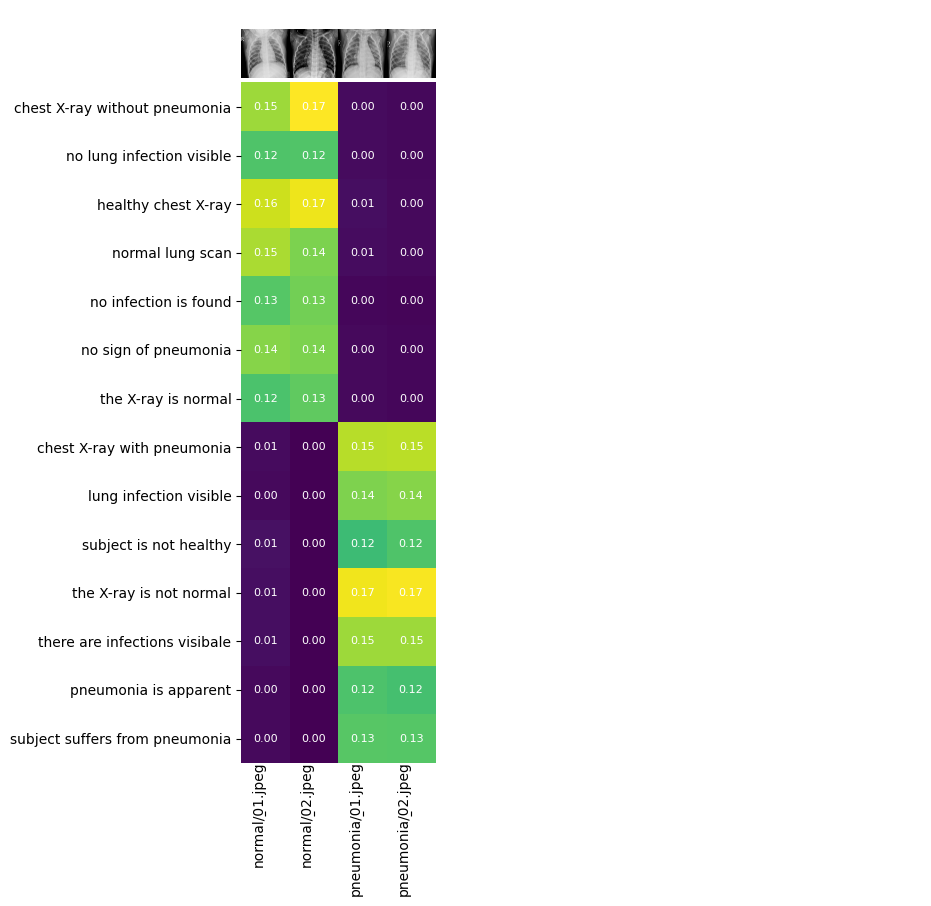

In [19]:
image_names = [name.replace("./assets/", "") for name in image_names]
similiarity_plot(probs.cpu().t(), prompts, images_orig, image_names)